In [1]:
from keras.models import Sequential,Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D,Input,Concatenate,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator


In [2]:
def inception(x,filtreler):


  #1x1 
  yol1=Conv2D(filters=filtreler[0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)

  #1x1 ->3x3 
  yol2=Conv2D(filters=filtreler[1][0],kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
  yol2=Conv2D(filters=filtreler[1][1],kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(yol2)

  #1x1->5x5 
  yol3=Conv2D(filters=filtreler[2][0],kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
  yol3=Conv2D(filters=filtreler[2][1],kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')(yol3)

  #3x3->1x1 
  yol4=MaxPooling2D(pool_size=(3,3),strides=1,padding='same')(x)
  yol4=Conv2D(filters=filtreler[3],kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(yol4)

  return Concatenate(axis=-1)([yol1,yol2,yol3,yol4])




In [3]:
def auxilary(x,name=None):
  layer=AveragePooling2D(pool_size=(5,5),strides=3,padding='valid')(x)
  layer=Conv2D(128,kernel_size=(1,1),padding='same',activation='relu')(layer)
  layer=Flatten()(layer)
  layer=Dense(256,activation='relu')(layer)
  layer=Dense(3,activation='softmax',name=name)(layer)

  return layer


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
input_layer=Input(shape=(224,224,3))

#stage1 
layer=Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu')(input_layer)
layer=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)
layer=BatchNormalization()(layer)

#stage 2
layer=Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(layer)
layer=Conv2D(192,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(layer)
layer=BatchNormalization()(layer)
layer=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)

#stage 3
layer=inception(layer,[64,(96,128),(16,32),32])#3a
layer=inception(layer,[128,(128,192),(32,96),64])#3b
layer=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)

#stage 4
layer=inception(layer,[192,(96,208),(16,48),64])#4a
aux1=auxilary(layer,name='aux1')
layer=inception(layer,[160,(112,224),(24,64),64])#4b
layer=inception(layer,[128,(128,256),(24,64),64])#4c
layer=inception(layer,[112,(144,288),(32,64),64])#4d
aux2=auxilary(layer,name='aux2')
layer=inception(layer,[256,(160,320),(32,128),128])#4e
layer=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)

#stage 5
layer=inception(layer,[256,(160,320),(32,128),128])#5a
layer=inception(layer,[384,(192,384),(48,128),128])#5b
layer=AveragePooling2D(pool_size=(7,7),strides=1,padding='valid')(layer)

#stage 6

layer=Flatten()(layer)
main_out=Dense(3,activation='softmax',name='main_out')(layer)

model=Model(inputs=input_layer,outputs=[main_out,aux1,aux2])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
trainPath="/content/drive/MyDrive/deeplearning/final odev/chest_xray/train/"
testPath="/content/drive/MyDrive/deeplearning/final odev/chest_xray/test/"

trainDataGen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

testDataGen=ImageDataGenerator(rescale=1./255)

trainGen=trainDataGen.flow_from_directory(
    trainPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    subset='training'
)

valGen=trainDataGen.flow_from_directory(
    trainPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    subset='validation'
)

testGen=testDataGen.flow_from_directory(
    testPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1
)

Found 4711 images belonging to 3 classes.
Found 521 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [7]:


from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks=[EarlyStopping(monitor='val_loss',patience=110), ModelCheckpoint(filepath="beset_model.h5",monitor='val_loss',save_best_only=True)]

model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])

history=model.fit(
    trainGen,
    steps_per_epoch=trainGen.samples//128,
    validation_data=valGen,
    epochs=10,
    validation_steps=valGen.samples//128,
    callbacks=callbacks
)

Epoch 1/10
36/36 [==============================] - 2089s 56s/step - loss: 4.4344 - main_out_loss: 1.4879 - aux1_loss: 1.6767 - aux2_loss: 1.2698 - main_out_accuracy: 0.5047 - aux1_accuracy: 0.4978 - aux2_accuracy: 0.4747 - val_loss: 3.2600 - val_main_out_loss: 1.0794 - val_aux1_loss: 1.1022 - val_aux2_loss: 1.0784 - val_main_out_accuracy: 0.4863 - val_aux1_accuracy: 0.4863 - val_aux2_accuracy: 0.4863
Epoch 2/10
36/36 [==============================] - 56s 2s/step - loss: 2.1088 - main_out_loss: 0.7460 - aux1_loss: 0.6704 - aux2_loss: 0.6924 - main_out_accuracy: 0.6747 - aux1_accuracy: 0.7086 - aux2_accuracy: 0.7048 - val_loss: 3.9367 - val_main_out_loss: 1.3207 - val_aux1_loss: 1.2341 - val_aux2_loss: 1.3819 - val_main_out_accuracy: 0.4824 - val_aux1_accuracy: 0.4824 - val_aux2_accuracy: 0.4824
Epoch 3/10
36/36 [==============================] - 56s 2s/step - loss: 1.8522 - main_out_loss: 0.6536 - aux1_loss: 0.5803 - aux2_loss: 0.6183 - main_out_accuracy: 0.7147 - aux1_accuracy: 0.749

In [8]:
import matplotlib.pyplot as plt

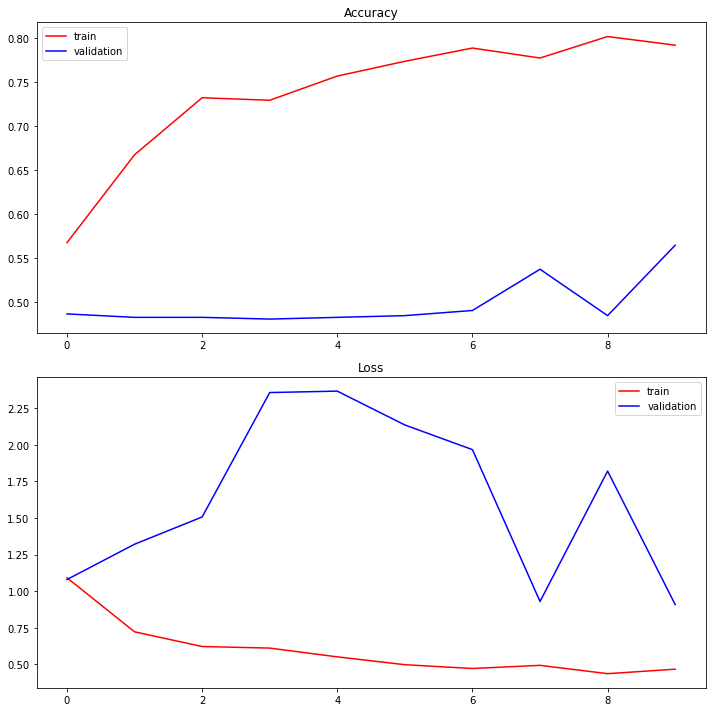

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["main_out_accuracy"],color='r',label='train')
plt.plot(history.history["val_main_out_accuracy"],color='b',label='validation')
plt.legend(loc='best')


plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["main_out_loss"],color='r',label='train')
plt.plot(history.history["val_main_out_loss"],color='b',label='validation')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [10]:
score = model.evaluate(valGen)
print("Val Loss", score[1])
print("Val Accuracy", score[4]*100)

score = model.evaluate(trainGen)
print("Train Loss", score[1])
print("Train Accuracy", score[4]*100)

score = model.evaluate(testGen)
print("Test Loss", score[1])
print("Test Accuracy", score[4]*100)

5/5 [==============================] - 6s 1s/step - loss: 2.4559 - main_out_loss: 0.9131 - aux1_loss: 0.7003 - aux2_loss: 0.8425 - main_out_accuracy: 0.5605 - aux1_accuracy: 0.6833 - aux2_accuracy: 0.6200
Val Loss 0.9131311774253845
Val Accuracy 56.046062707901
37/37 [==============================] - 50s 1s/step - loss: 2.3736 - main_out_loss: 0.8952 - aux1_loss: 0.6599 - aux2_loss: 0.8184 - main_out_accuracy: 0.5820 - aux1_accuracy: 0.7094 - aux2_accuracy: 0.6154
Train Loss 0.895231306552887
Train Accuracy 58.204203844070435
624/624 [==============================] - 220s 352ms/step - loss: 3.8179 - main_out_loss: 1.3472 - aux1_loss: 1.1348 - aux2_loss: 1.3359 - main_out_accuracy: 0.4327 - aux1_accuracy: 0.5433 - aux2_accuracy: 0.4808
Test Loss 1.3472373485565186
Test Accuracy 43.26923191547394


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


scoreSeg = model.evaluate_generator(testGen,624)
testGen.reset()
predict = model.predict_generator(testGen,624)


print('tahmini Değer')
print(np.argmax(predict, axis=2))
print('========================================================================')

print('Gerçek Değer')
print(testGen.classes)

print(testGen.class_indices)

pred=np.argmax(predict, axis=2)
print('========================================================================')
print("Confusion Matrix")
print(confusion_matrix(testGen,pred))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


tahmini Değer
[[0 1 1 ... 1 1 1]
 [1 2 1 ... 1 1 2]
 [1 1 1 ... 1 1 2]]
Gerçek Değer
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 

ValueError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Results")
print(classification_report(testGen.classes,pred,target_names=(sorted(testGen.class_indices.keys()))))

from sklearn.metrics import accuracy_score
print ('Accuracy:', accuracy_score(testGen.classes, np.argmax(predict, axis=1)))

print('Test accuracy :', '%', scoreSeg[1]*100)

Results


NameError: ignored